In [3]:
import pandas as pd
import os
import numpy as np
import gspread
ROOTFOLDER = "D:/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was/_data"
RAW = f"{ROOTFOLDER}/_raw"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated/c_analysis"


# Goal: visualize basic statistics
1. Get mean {SVF} per each city per yeargroup
2. Plot road fatality and dalys per country

In [47]:
FILENAME_CROSS = "01_seg_dalys_cross.csv"
y = ['diabetes_mellitus_cap', 'mental_and_substance_use_disorders_cap',
       'cardiovascular_diseases_cap', 'road_injury_cap','num_person_killed_per_lakh']

crossdf = pd.read_csv(os.path.join(CURATED_FOLDER, FILENAME_CROSS))

# set up conditions
condition = (crossdf['person_count']>0)&(crossdf['road']>0)&(crossdf['res']==6)
crossdf_city = crossdf[condition].groupby(['country_clean', 'city_lower']).mean().reset_index()
crossdf_city

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_36456\2974953361.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  crossdf = pd.read_csv(os.path.join(CURATED_FOLDER, FILENAME_CROSS))


,country_clean,city_lower,ring,building,greenery,street_furniture,sidewalk,car,person,bike,...,log_sidewalk,log_car,log_person,log_bike,log_sky,log_road,log_diabetes_mellitus_cap,log_mental_and_substance_use_disorders_cap,log_cardiovascular_diseases_cap,log_road_injury_cap
0,Argentina,buenosaires,-1.000000,24521.677011,21802.479263,95.329455,6618.695879,7841.147511,128.545343,60.283723,...,8.649293,8.892303,4.547780,3.613757,10.636870,10.767951,6.672222,7.730275,8.312618,6.742781
1,Australia,sydney,1.000000,7698.482670,36709.834295,86.978293,4547.280055,2919.298136,33.911169,16.296498,...,8.022291,7.710056,3.104899,1.372305,10.822842,10.689364,6.655170,8.161513,7.922904,5.758244
2,Austria,vienna,1.061538,13818.968302,38391.290713,107.785698,4031.004695,3712.665812,38.690409,34.631426,...,7.822736,7.699166,3.267337,2.622706,10.990492,10.614496,6.870660,7.963986,8.560021,5.699787
3,Bangladesh,dhaka,0.532787,31005.262190,26656.221631,115.847142,3080.738262,2367.288309,624.135538,491.040680,...,7.633741,7.505445,6.200728,5.852759,10.585197,10.121397,6.511315,7.592283,8.251358,6.969424
4,Bangladesh,rajshahi,-0.612613,10892.984464,54215.802166,61.762480,697.890057,587.439084,265.809316,283.187181,...,5.750309,6.001451,5.414156,5.331406,10.729675,9.982898,6.511315,7.592283,8.251358,6.969424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,United States of America,philadelphia,0.592593,11979.033242,37925.066484,62.612260,5269.463362,4404.947146,30.674664,4.759186,...,8.082851,8.081056,3.184723,1.226406,10.679932,10.745809,7.170241,8.450323,8.544205,6.583532
123,United States of America,"portland,or",-1.000000,6313.382363,40317.392284,88.588519,3793.299677,2402.829069,21.805098,3.474202,...,7.824601,7.545506,3.040221,1.205018,10.713020,10.711210,7.170241,8.450323,8.544205,6.583532
124,United States of America,raleigh,1.712121,7500.234611,50973.221762,77.482200,5850.217026,1863.819340,30.567242,2.953776,...,8.352461,7.363365,3.013834,0.806771,10.907789,10.916479,7.170241,8.450323,8.544205,6.583532
125,United States of America,sanfrancisco,-1.000000,16038.468862,19592.086182,86.352634,3915.223816,4998.560458,64.697695,18.895038,...,7.943344,8.411235,3.924834,2.831633,10.866901,10.840035,7.170241,8.450323,8.544205,6.583532


In [31]:

crossdf_country = crossdf[condition].groupby(['country_clean']).mean().reset_index()
# plot the dalys from road injury first
crossdf_country = crossdf_country[y+['country_clean']].sort_values(by='road_injury_cap', ascending=False)


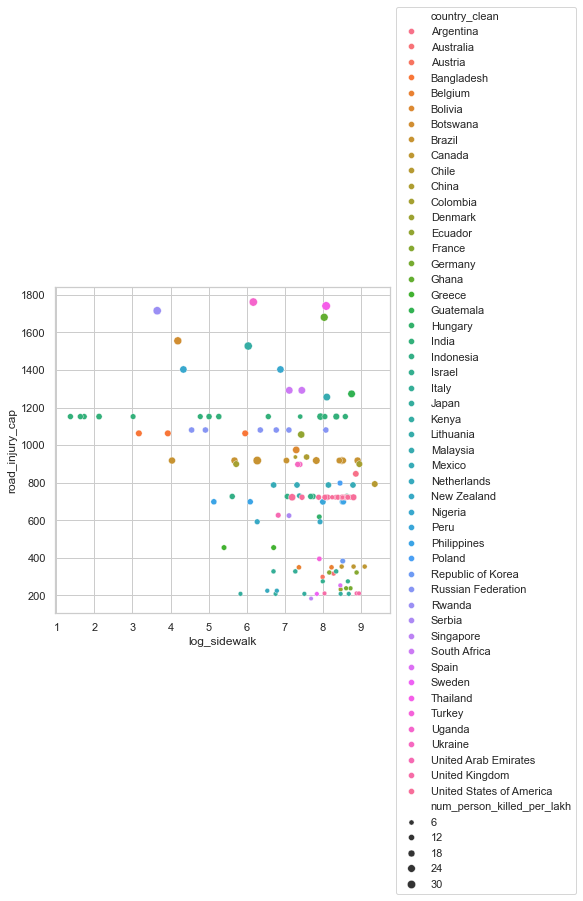

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.scatterplot(data=crossdf_city, 
                x='log_sidewalk', 
                y='road_injury_cap', 
                size = 'num_person_killed_per_lakh',
                hue='country_clean')
# take legend out
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

<Figure size 432x432 with 0 Axes>

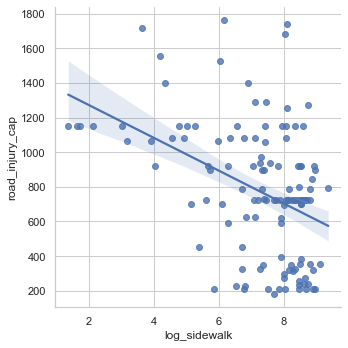

In [33]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.lmplot(data=crossdf_city, 
                x='log_sidewalk', 
                y='road_injury_cap', 
                )

In [50]:
crossdf['country_clean'].nunique()

50

<AxesSubplot:xlabel='sidewalk_person', ylabel='country_clean'>

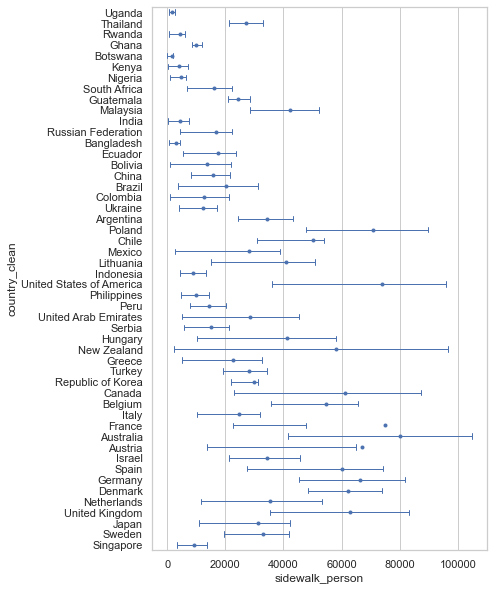

In [49]:
plt.figure(figsize=(6, 10))
# sns.boxplot(data=crossdf[condition].sort_values('road_injury_cap', ascending=False), 
#                 x='log_sidewalk', 
#                 y='country_clean', 
#                 )
viz = crossdf[condition].sort_values('road_injury_cap', ascending=False)
viz['sidewalk_person'] = viz['sidewalk']/viz['person_count']
order = viz['country_clean'].unique()
sns.pointplot(
        data = viz,
        x='sidewalk_person',
        y='country_clean',
        order = order,
        # errorbar= 'ci',
        markersize = 4,
        errorbar = ('pi', 50),
        capsize=0.5,
        err_kws = {'linewidth':1},
        linewidth=0
        # ci = 'sd',
        
    )

<Figure size 432x432 with 0 Axes>

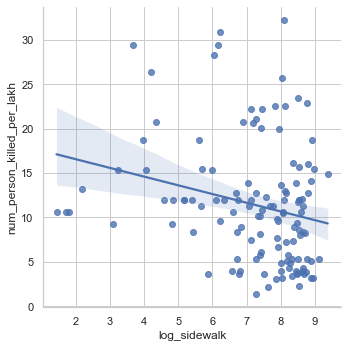

In [22]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.lmplot(data=crossdf_city, 
                x='log_sidewalk', 
                y='num_person_killed_per_lakh', )